# OSU Bandwidth Experiments with MI250 (and A100) nodes on JURECA DC

Investigation by [Andreas Herten](https://www.fz-juelich.de/profile/herten_a) for [X-Dev Blog](https://x-dev.pages.jsc.fz-juelich.de/) in July 2022, see https://go.fzj.de/jsc-amdgpu-eval.

## Setup

Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter

In [2]:
%matplotlib inline
formatter = EngFormatter(sep="\N{THIN SPACE}", unit='B/s')
plt.rcParams.update({"text.usetex": False})

Source file names

In [3]:
names_files = {
    '50': {
        'large': 'out-10605265-jrc0850-large.csv',
        'small': 'out-10605265-jrc0850-small.csv'
    },
    '439-cuda': {
        'large': 'out-10647684-jrc0439-large.csv',
        'small': 'out-10647684-jrc0439-small.csv'
    }
}

Read source files in dicts of dicts of Dataframes

In [4]:
dfs = dict()
for host, sizes in names_files.items():
    dfs[host] = dict()
    for size, filename in sizes.items():
        dfs[host][size] = pd.read_csv(filename)

Make pivot DataFrames of GPU vs GPU

In [5]:
dfs_pivot = dict()
for host, df_sizes in dfs.items():
    dfs_pivot[host] = dict()
    for size, df in df_sizes.items():
        dfs_pivot[host][size] = dfs[host][size].pivot(index="GPU 1", columns="GPU 2", values="Bandwidth / MB/s")

Most values – as far as I can tell – are in _Megabyte per seconds_; I'd rather like to have them in _Mebibyte per seconds_.

In [6]:
def convert_MB2MiB(val):
    return val * 1000 * 1000 / (1024*1024)

## AMD Instinct MI250
### Absolute Values

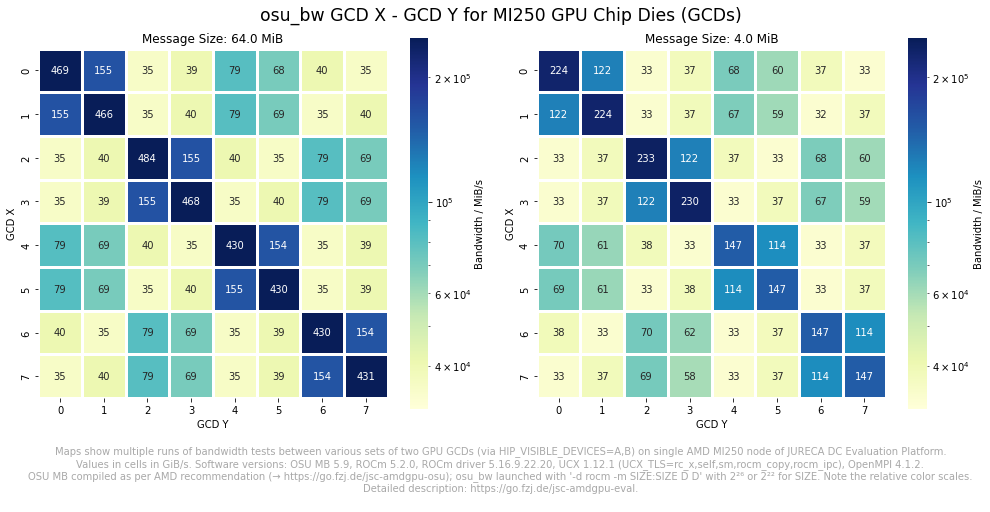

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6))
for ax, msg_size in zip(axs, dfs_pivot['50'].keys()):
    msg_size_byte = dfs['50'][msg_size]["Message Size / Byte"][0]
    ax = sns.heatmap(
        convert_MB2MiB(dfs_pivot['50'][msg_size]), 
        cmap="YlGnBu", 
        linewidths=3, 
        norm=LogNorm(dfs_pivot['50']['small'].min().min()*0.9, dfs_pivot['50']['small'].max().max()), 
        square=True, 
        fmt="2,.0f", 
        cbar_kws={'label': 'Bandwidth / MiB/s'},
        annot=round(convert_MB2MiB(dfs_pivot['50'][msg_size])/1024, 2),
        #mask=mask,
        ax=ax,
        vmin=dfs_pivot['50']['small'].min().min(),
        vmax=dfs_pivot['50']['small'].max().max()
    )
    ax.set_ylabel('GCD X')
    ax.set_xlabel('GCD Y')
    ax.set_title(f'Message Size: {round(msg_size_byte/(1024*1024), 2)} MiB')
fig.suptitle("osu_bw GCD X - GCD Y for MI250 GPU Chip Dies (GCDs)", fontsize='xx-large')
disclaimer = """
Maps show multiple runs of bandwidth tests between various sets of two GPU GCDs (via HIP_VISIBLE_DEVICES=A,B) on single AMD MI250 node of JURECA DC Evaluation Platform.
Values in cells in GiB/s. Software versions: OSU MB 5.9, ROCm 5.2.0, ROCm driver 5.16.9.22.20, UCX 1.12.1 (UCX_TLS=rc_x,self,sm,rocm_copy,rocm_ipc), OpenMPI 4.1.2.
OSU MB compiled as per AMD recommendation (→ https://go.fzj.de/jsc-amdgpu-osu); osu_bw launched with '-d rocm -m SIZE:SIZE D D' with 2²⁶ or 2²² for SIZE. Note the relative color scales.
Detailed description: https://go.fzj.de/jsc-amdgpu-eval.
"""
fig.text(0.5, -0.01, disclaimer, color="darkgray", horizontalalignment="center", verticalalignment="top")
fig.tight_layout()
for ext in ['png', 'pdf', 'svg']:
    fig.savefig(f"osu_bw_amd_mi250.{ext}", dpi=300, bbox_inches='tight')

### Relative Values

Let's look at how well-used links are and normalize to the respective available theoretical peak bandwidth. Because there are different number of links going between different GCDs, the normalization factor is different. There are GCDs with 4 links, 2 links, and 1 link.

For to-own-memory speed I could find 3200 GT/s as a cumulative bi-directional number over a 8192 bit wide bus. I take the half of this as the resulting 3267.8 GB/s is for the _full_ MCM.

In [8]:
xgmi_speed = 50000  #MB/s

In [9]:
dfs_rel = {'50': {}}
for msg_size, _df in dfs_pivot['50'].items():
#for msg_size, _df in [('large', this_df_pivot['large'])]:
    mask_xgmi_self = (_df > 200000)
    mask_xgmi_4 = (_df > 100000) & (_df < 200000)
    mask_xgmi_2 = (_df > 50000) & (_df < 100000)
    mask_xgmi_1 = (_df < 50000)
    #
    _df_xgmi_self =  convert_MB2MiB(_df[mask_xgmi_self]) / (3200 * 1000 * 1000 * 1000 / 1024 / 1024 / 1024  * 8192 / 8 / 2)
    _df_xgmi_4 =  convert_MB2MiB(_df[mask_xgmi_4]) / convert_MB2MiB(4*xgmi_speed)
    _df_xgmi_2 =  convert_MB2MiB(_df[mask_xgmi_2]) / convert_MB2MiB(2*xgmi_speed)
    _df_xgmi_1 = convert_MB2MiB(_df[mask_xgmi_1]) / convert_MB2MiB(1*xgmi_speed)
    dfs_rel['50'][msg_size] = _df_xgmi_4.combine_first(_df_xgmi_2).combine_first(_df_xgmi_1).combine_first(_df_xgmi_self)

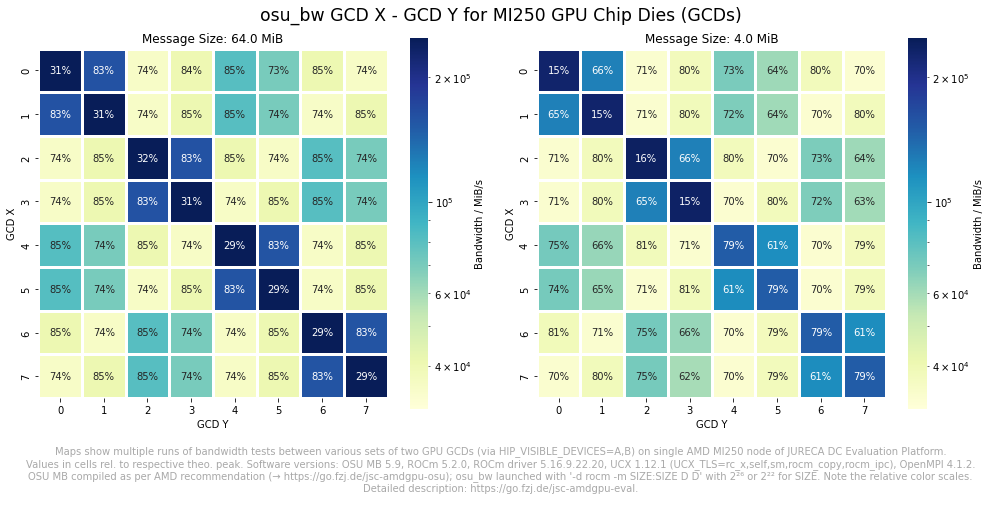

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6))
for ax, msg_size in zip(axs, dfs_pivot['50'].keys()):
    msg_size_byte = dfs['50'][msg_size]["Message Size / Byte"][0]
    ax = sns.heatmap(
        convert_MB2MiB(dfs_pivot['50'][msg_size]), 
        cmap="YlGnBu", 
        linewidths=3, 
        norm=LogNorm(dfs_pivot['50']['small'].min().min()*0.9, dfs_pivot['50']['small'].max().max()), 
        square=True, 
        fmt=",.0%", 
        cbar_kws={'label': 'Bandwidth / MiB/s'},
        annot=dfs_rel['50'][msg_size],
        #mask=mask,
        ax=ax,
        vmin=dfs_pivot['50']['small'].min().min(),
        vmax=dfs_pivot['50']['small'].max().max()
    )
    ax.set_ylabel('GCD X')
    ax.set_xlabel('GCD Y')
    ax.set_title(f'Message Size: {round(msg_size_byte/(1024*1024), 2)} MiB')
fig.suptitle("osu_bw GCD X - GCD Y for MI250 GPU Chip Dies (GCDs)", fontsize='xx-large')
disclaimer = """
Maps show multiple runs of bandwidth tests between various sets of two GPU GCDs (via HIP_VISIBLE_DEVICES=A,B) on single AMD MI250 node of JURECA DC Evaluation Platform.
Values in cells rel. to respective theo. peak. Software versions: OSU MB 5.9, ROCm 5.2.0, ROCm driver 5.16.9.22.20, UCX 1.12.1 (UCX_TLS=rc_x,self,sm,rocm_copy,rocm_ipc), OpenMPI 4.1.2.
OSU MB compiled as per AMD recommendation (→ https://go.fzj.de/jsc-amdgpu-osu); osu_bw launched with '-d rocm -m SIZE:SIZE D D' with 2²⁶ or 2²² for SIZE. Note the relative color scales.
Detailed description: https://go.fzj.de/jsc-amdgpu-eval.
"""
fig.text(0.5, -0.01, disclaimer, color="darkgray", horizontalalignment="center", verticalalignment="top")
fig.tight_layout()
for ext in ['png', 'pdf', 'svg']:
    fig.savefig(f"osu_bw_amd_mi250-rel.{ext}", dpi=300, bbox_inches='tight')

## NVIDIA A100
### Absolute Values

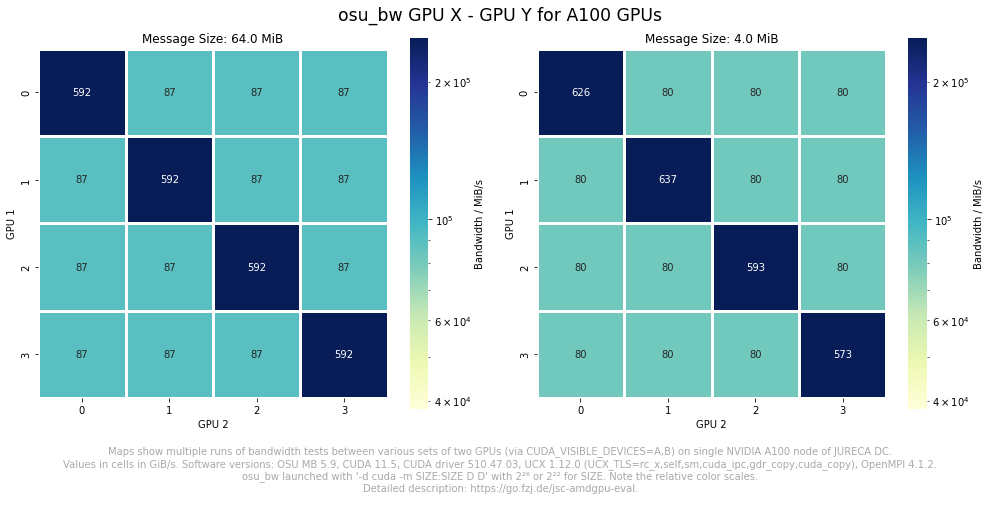

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6))
for ax, msg_size in zip(axs, dfs_pivot['439-cuda'].keys()):
    msg_size_byte = dfs['439-cuda'][msg_size]["Message Size / Byte"][0]
    ax = sns.heatmap(
        convert_MB2MiB(dfs_pivot['439-cuda'][msg_size]), 
        cmap="YlGnBu", 
        linewidths=3, 
        #norm=LogNorm(this_df_pivot[msg_size].min().min(), this_df_pivot[msg_size].max().max()), 
        norm=LogNorm(dfs_pivot['50']['small'].min().min()*1.1, dfs_pivot['50']['small'].max().max()), 
        square=True, 
        fmt="2,.0f",
        cbar_kws={'label': 'Bandwidth / MiB/s'},
        annot=round(convert_MB2MiB(dfs_pivot['439-cuda'][msg_size])/1024, 2),
        #mask=mask,
        ax=ax,
        vmin=dfs_pivot['439-cuda']['small'].min().min(),
        vmax=dfs_pivot['439-cuda']['small'].max().max()
    )
    ax.set_title(f'Message Size: {round(msg_size_byte/(1024*1024), 2)} MiB')
fig.suptitle("osu_bw GPU X - GPU Y for A100 GPUs", fontsize='xx-large')
disclaimer = """
Maps show multiple runs of bandwidth tests between various sets of two GPUs (via CUDA_VISIBLE_DEVICES=A,B) on single NVIDIA A100 node of JURECA DC.
Values in cells in GiB/s. Software versions: OSU MB 5.9, CUDA 11.5, CUDA driver 510.47.03, UCX 1.12.0 (UCX_TLS=rc_x,self,sm,cuda_ipc,gdr_copy,cuda_copy), OpenMPI 4.1.2.
osu_bw launched with '-d cuda -m SIZE:SIZE D D' with 2²⁶ or 2²² for SIZE. Note the relative color scales.
Detailed description: https://go.fzj.de/jsc-amdgpu-eval.
"""
fig.text(0.5, -0.01, disclaimer, color="darkgray", horizontalalignment="center", verticalalignment="top")
fig.tight_layout()
for ext in ['png', 'pdf', 'svg']:
    fig.savefig(f"osu_bw_nvidia_a100.{ext}", dpi=300, bbox_inches='tight')

### Relative Values

In [12]:
nvlink_speed = 25000  # MB/s

In [13]:
dfs_rel['439-cuda'] = {}
for msg_size, _df in dfs_pivot['439-cuda'].items():
    mask_nvlink_self = (_df > 200000)
    mask_nvlink_4 = (_df < 200000)
    #
    _df_nvlink_self =  convert_MB2MiB(_df[mask_nvlink_self]) / convert_MB2MiB(1555.2 * 1000)
    _df_nvlink_4 =  convert_MB2MiB(_df[mask_nvlink_4]) / convert_MB2MiB(4*nvlink_speed)
    dfs_rel['439-cuda'][msg_size] = _df_nvlink_4.combine_first(_df_nvlink_self)

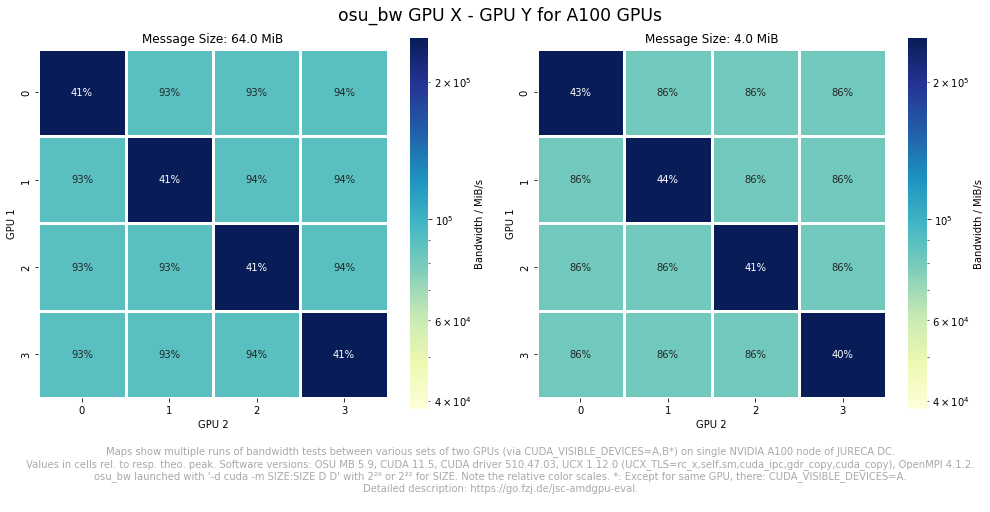

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6))
for ax, msg_size in zip(axs, dfs_pivot['439-cuda'].keys()):
    msg_size_byte = dfs['439-cuda'][msg_size]["Message Size / Byte"][0]
    ax = sns.heatmap(
        convert_MB2MiB(dfs_pivot['439-cuda'][msg_size]), 
        cmap="YlGnBu", 
        linewidths=3,
        norm=LogNorm(dfs_pivot['50']['small'].min().min()*1.1, dfs_pivot['50']['small'].max().max()), 
        square=True, 
        fmt=",.0%", 
        cbar_kws={'label': 'Bandwidth / MiB/s'},
        annot=dfs_rel['439-cuda'][msg_size],
        #mask=mask,
        ax=ax,
        vmin=dfs_pivot['439-cuda']['small'].min().min(),
        vmax=dfs_pivot['439-cuda']['small'].max().max()
    )
    ax.set_title(f'Message Size: {round(msg_size_byte/(1024*1024), 2)} MiB')
fig.suptitle("osu_bw GPU X - GPU Y for A100 GPUs", fontsize='xx-large')
disclaimer = """
Maps show multiple runs of bandwidth tests between various sets of two GPUs (via CUDA_VISIBLE_DEVICES=A,B*) on single NVIDIA A100 node of JURECA DC.
Values in cells rel. to resp. theo. peak. Software versions: OSU MB 5.9, CUDA 11.5, CUDA driver 510.47.03, UCX 1.12.0 (UCX_TLS=rc_x,self,sm,cuda_ipc,gdr_copy,cuda_copy), OpenMPI 4.1.2.
osu_bw launched with '-d cuda -m SIZE:SIZE D D' with 2²⁶ or 2²² for SIZE. Note the relative color scales. *: Except for same GPU, there: CUDA_VISIBLE_DEVICES=A.
Detailed description: https://go.fzj.de/jsc-amdgpu-eval.
"""
fig.text(0.5, -0.01, disclaimer, color="darkgray", horizontalalignment="center", verticalalignment="top")
fig.tight_layout()
for ext in ['png', 'pdf', 'svg']:
    fig.savefig(f"osu_bw_nvidia_a100-rel.{ext}", dpi=300, bbox_inches='tight')

## Bonus: Direct Comparisons

This is a bit ugly because I created the above images in a set of three loops (msg_size x abs|rel x vendor). Also, this will only run in Python >3.10 because I wanted to test out the new `match` statement.

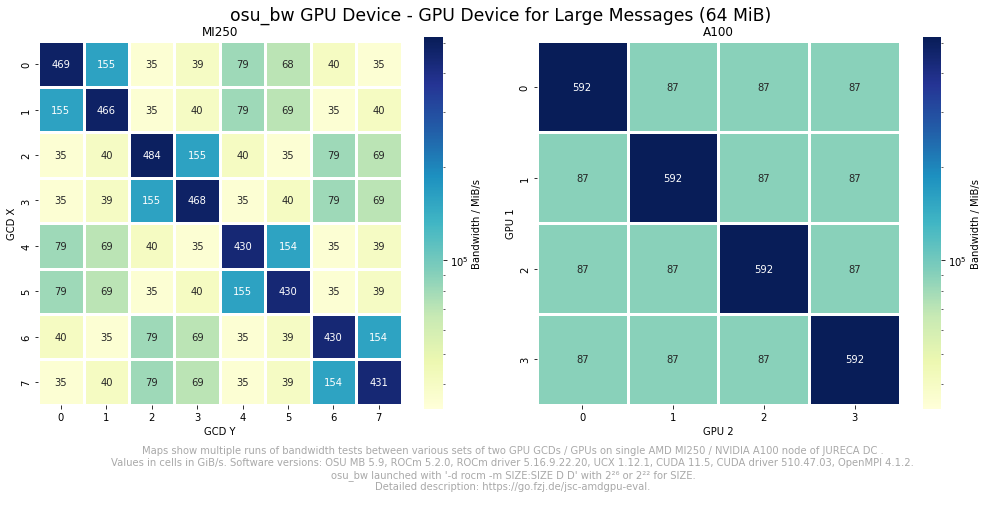

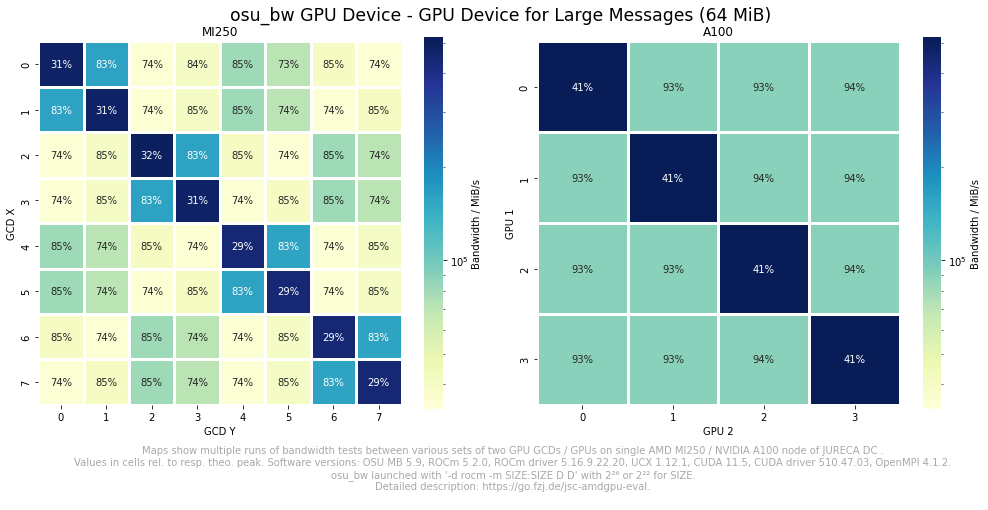

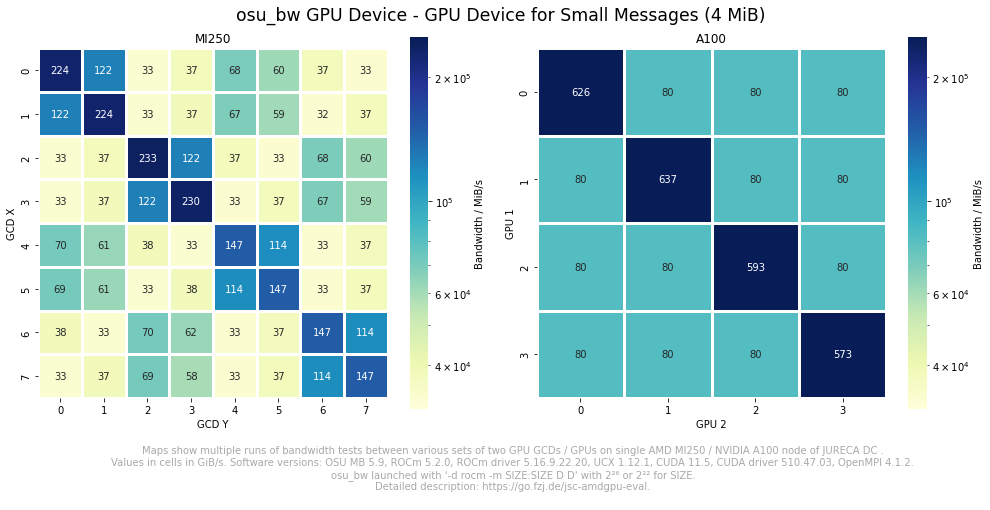

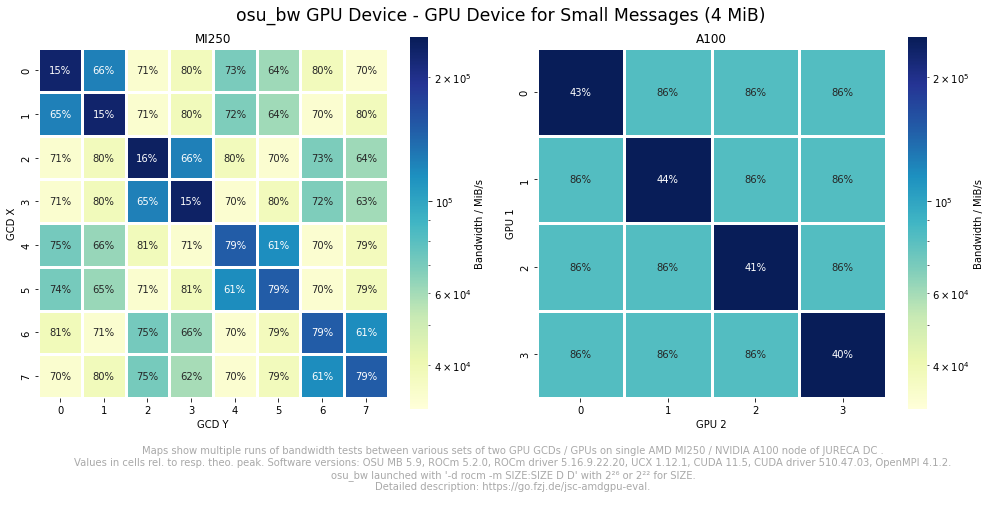

In [19]:
for msg_size in ['large', 'small']:
    for cell_content in ['abs', 'rel']:
        fig, axs = plt.subplots(ncols=2, figsize=(14,6))
        for ax, vendor in zip(axs, [dfs_pivot['50'], dfs_pivot['439-cuda']]):
            match len(vendor[msg_size]):
                case 8:
                    vendor_name="AMD"
                    match cell_content:
                        case 'abs':
                            _fmt = "2,.0f"
                            _annot = round(convert_MB2MiB(vendor[msg_size])/1024, 2)
                        case 'rel':
                            _fmt = ",.0%"
                            _annot = dfs_rel['50'][msg_size]
                case 4:
                    vendor_name="NVIDIA"
                    match cell_content:
                        case 'abs':
                            _fmt = "2,.0f"
                            _annot = round(convert_MB2MiB(vendor[msg_size])/1024, 2)
                        case 'rel':
                            _ftm = ",.0%"
                            _annot = dfs_rel['439-cuda'][msg_size]
            msg_size_byte = dfs['50'][msg_size]["Message Size / Byte"][0]
            ax = sns.heatmap(
                convert_MB2MiB(vendor[msg_size]), 
                cmap="YlGnBu", 
                linewidths=3, 
                norm=LogNorm(dfs_pivot['50'][msg_size].min().min()*0.9, dfs_pivot['50'][msg_size].max().max()), 
                square=True, 
                cbar_kws={'label': 'Bandwidth / MiB/s'},
                fmt=_fmt,
                annot=_annot,
                #mask=mask,
                ax=ax,
                vmin=dfs_pivot['50'][msg_size].min().min(),
                vmax=dfs_pivot['50'][msg_size].max().max()
            )
            if vendor_name == "AMD":
                ax.set_ylabel('GCD X')
                ax.set_xlabel('GCD Y')
                ax.set_title('MI250')
            if vendor_name == "NVIDIA":
                ax.set_title('A100')
        fig.suptitle(f"osu_bw GPU Device - GPU Device for {msg_size.capitalize()} Messages ({int(round(msg_size_byte/(1024*1024), 2))} MiB)", fontsize='xx-large')
        disclaimer = f"""
        Maps show multiple runs of bandwidth tests between various sets of two GPU GCDs / GPUs on single AMD MI250 / NVIDIA A100 node of JURECA DC .
        Values in cells {'in GiB/s' if cell_content == 'abs' else 'rel. to resp. theo. peak'}. Software versions: OSU MB 5.9, ROCm 5.2.0, ROCm driver 5.16.9.22.20, UCX 1.12.1, CUDA 11.5, CUDA driver 510.47.03, OpenMPI 4.1.2.
        osu_bw launched with '-d rocm -m SIZE:SIZE D D' with 2²⁶ or 2²² for SIZE.
        Detailed description: https://go.fzj.de/jsc-amdgpu-eval.
        """
        fig.text(0.5, -0.01, disclaimer, color="darkgray", horizontalalignment="center", verticalalignment="top")
        fig.tight_layout()
        for ext in ['png', 'pdf', 'svg']:
            fig.savefig(f"osu_bw_amd_vs_a100-{msg_size}-{cell_content}.{ext}", dpi=300, bbox_inches='tight')

# Raw Data

In the following, the raw data of the analysis here is shown. The data is read from the CSV file and presented in base64-encoding. To write to a file (or a `StringIO` object directly), just invert the procedure and copy the string and b64decode it.

In [16]:
from pathlib import Path
import base64

In [17]:
for host, sizes in names_files.items():
    for size, file in sizes.items():
        _file_content = Path(file).read_text()
        b64_content = base64.b64encode(_file_content.encode('utf-8'))
        print(f'df[{host}][{size}]: {b64_content}')

df[50][large]: b'R1BVIDEsR1BVIDIsTWVzc2FnZSBTaXplIC8gQnl0ZSxCYW5kd2lkdGggLyBNQi9zCjAsMCw2NzEwODg2NCw1MDMzMjYuNTIKMCwxLDY3MTA4ODY0LDE2NjgxMS44NAowLDIsNjcxMDg4NjQsMzcxMTUuNjkKMCwzLDY3MTA4ODY0LDQyMTczLjczCjAsNCw2NzEwODg2NCw4NDgzMS42NAowLDUsNjcxMDg4NjQsNzM0NjQuOTQKMCw2LDY3MTA4ODY0LDQyNjQ2LjU3CjAsNyw2NzEwODg2NCwzNzE4NC42NQoxLDAsNjcxMDg4NjQsMTY2NjEwLjAwCjEsMSw2NzEwODg2NCw1MDA0NTEuMzcKMSwyLDY3MTA4ODY0LDM3MTEwLjg2CjEsMyw2NzEwODg2NCw0MjQxMC43NwoxLDQsNjcxMDg4NjQsODQ3NTMuNDQKMSw1LDY3MTA4ODY0LDczNTg3LjI4CjEsNiw2NzEwODg2NCwzNzE2NC4yNAoxLDcsNjcxMDg4NjQsNDI1NDguODYKMiwwLDY3MTA4ODY0LDM3MTU4Ljg3CjIsMSw2NzEwODg2NCw0MjQzMy43MgoyLDIsNjcxMDg4NjQsNTE5NzI0Ljg5CjIsMyw2NzEwODg2NCwxNjY2NDQuODAKMiw0LDY3MTA4ODY0LDQyNTA4LjYwCjIsNSw2NzEwODg2NCwzNzE4Ny43OAoyLDYsNjcxMDg4NjQsODQ2MzMuNzIKMiw3LDY3MTA4ODY0LDczODE2LjMzCjMsMCw2NzEwODg2NCwzNzE1NC4zMQozLDEsNjcxMDg4NjQsNDIzODEuMDIKMywyLDY3MTA4ODY0LDE2NjU5OS43OQozLDMsNjcxMDg4NjQsNTAyODcwLjA3CjMsNCw2NzEwODg2NCwzNzE5Ni4xOQozLDUsNjcxMDg4NjQsNDI2MDYuOTIKMyw2LDY3MTA4ODY0LDg0NjA3LjU